In [665]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from prophet.diagnostics import cross_validation, performance_metrics
from suntime import Sun, SunTimeException
from datetime import timedelta
import ephem
import xgboost as xgb

In [2]:
def plot_predictions(predictions, actual_values):
    plt.figure(figsize=(14, 7))
    plt.plot(actual_values.index, actual_values, label='Actual Values', color='b')
    plt.plot(actual_values.index, predictions, label='Predicted Values', color='r')
    plt.xlabel('Index')
    plt.ylabel('System Production (W)')
    plt.title('Actual vs Predicted System Production (W)')
    plt.legend()
    plt.show()

In [163]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [673]:
def get_data():
    file_path = '/Users/mubashirahmad/Library/CloudStorage/OneDrive-UniversityofHertfordshire/BDTI-Shared-Resources/Projects/On-Going/PowerBox/powerbox/powerbox/Data/processed_datasets/SI_SP_merged_filtered.csv'
    # data = pd.read_csv(file_path, usecols=['Time', 'System Production (W)', 'ALLSKY_SFC_SW_DWN'])

    n = len(data)
    train_size = int(n * 0.80)
    valid_size = int(n * 0.15)

    train_data = data.iloc[:train_size]
    valid_data = data.iloc[train_size:train_size + valid_size]
    test_data = data.iloc[train_size + valid_size:]
    print('Training Set: ',len(train_data),'Validation Set: ', len(valid_data),'Test Set: ', len(test_data))
    
    return train_data, valid_data, test_data



## Random Forest Regressor

Mean Squared Error: 3556507151.876729


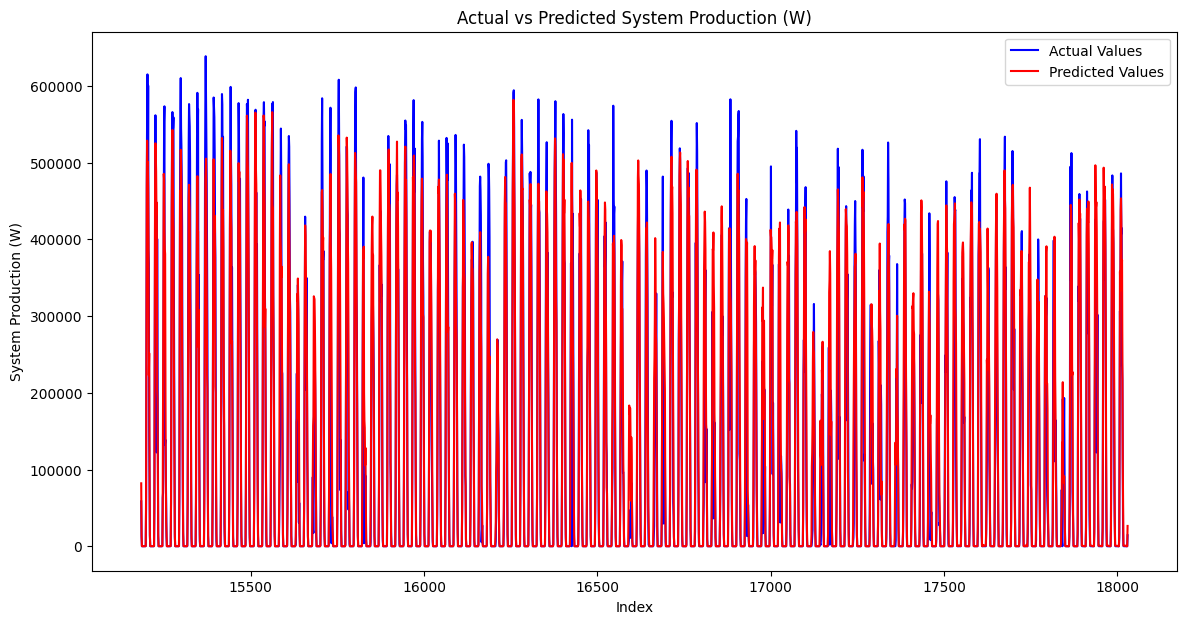

In [6]:

features = data.columns[:-1]  
features = features.drop('Time')


target = 'System Production (W)'
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data[features])
valid_data_scaled = scaler.transform(valid_data[features])


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data_scaled, train_data[target])


valid_predictions = model.predict(valid_data_scaled)


mse = mean_squared_error(valid_data[target], valid_predictions)
print("Mean Squared Error:", mse)

plot_predictions(valid_predictions, valid_data[target])

## ARIMAX

In [8]:

train_data = train_data.fillna(method='ffill').fillna(method='bfill')
valid_data = valid_data.fillna(method='ffill').fillna(method='bfill')
test_data = test_data.fillna(method='ffill').fillna(method='bfill')

train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)

train_data.dropna(inplace=True)
valid_data.dropna(inplace=True)
test_data.dropna(inplace=True)

assert not train_data.empty, "Training data is empty after cleaning."
assert not valid_data.empty, "Validation data is empty after cleaning."
assert not test_data.empty, "Test data is empty after cleaning."


features = data.columns[:-1]  
target = 'System Production (W)'
features = features.drop('Time')


scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_data[features])
valid_features_scaled = scaler.transform(valid_data[features])


train_features_scaled = pd.DataFrame(train_features_scaled, index=train_data.index, columns=features)
valid_features_scaled = pd.DataFrame(valid_features_scaled, index=valid_data.index, columns=features)


model = SARIMAX(train_data[target], exog=train_features_scaled, order=(2, 1, 2), seasonal_order=(1, 1, 1, 24))
model_fit = model.fit(disp=False)


valid_predictions = model_fit.predict(start=valid_data.index[0], end=valid_data.index[-1], exog=valid_features_scaled)


mse = mean_squared_error(valid_data[target], valid_predictions)
print("Mean Squared Error:", mse)


valid_predictions = model_fit.predict(start=valid_data.index[0], end=valid_data.index[-1], exog=valid_features_scaled)


mse = mean_squared_error(valid_data[target], valid_predictions)
print("Mean Squared Error:", mse)

plot_predictions(valid_predictions, valid_data[target])

/var/folders/vv/v6qpc6ns2mv0rnx87x54tqhr0000gn/T/ipykernel_5024/1495476013.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='ffill').fillna(method='bfill')
/var/folders/vv/v6qpc6ns2mv0rnx87x54tqhr0000gn/T/ipykernel_5024/1495476013.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  valid_data = valid_data.fillna(method='ffill').fillna(method='bfill')
/var/folders/vv/v6qpc6ns2mv0rnx87x54tqhr0000gn/T/ipykernel_5024/1495476013.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_data.fillna(method='ffill').fillna(method='bfill')


KeyboardInterrupt: 

In [53]:
train, valid, test =get_data()

15184 2847 949


In [54]:
train.head()

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_KT,ALLSKY_SRF_ALB,...,T2M,T2MDEW,T2MWET,QV2M,PRECTOTCORR,PS,WD10M,WS10M,Time,System Production (W)
0,2022,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.46,24.97,25.21,19.84,0.75,100.27,79.83,1.46,2022-01-01 00:00:00,0.0
1,2022,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,25.24,24.83,25.04,19.71,0.92,100.18,78.51,1.45,2022-01-01 01:00:00,0.0
2,2022,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,...,25.07,24.74,24.90,19.59,1.19,100.12,80.49,1.42,2022-01-01 02:00:00,0.0
3,2022,1,1,3,0.0,0.0,0.0,0.0,0.0,0.0,...,24.92,24.62,24.77,19.47,1.72,100.09,76.21,1.34,2022-01-01 03:00:00,0.0
4,2022,1,1,4,0.0,0.0,0.0,0.0,0.0,0.0,...,24.78,24.44,24.61,19.23,2.58,100.18,49.82,1.38,2022-01-01 04:00:00,0.0


In [374]:
def data_init():
    train, valid, test =get_data()
    train = train[['Time','System Production (W)']]
    train['Time'] = pd.to_datetime(train['Time'])
    train.set_index('Time', inplace=True)
    train = train.asfreq('h')
    # train['System Production (W)'] = np.log1p(train['System Production (W)'])
    scaler = StandardScaler()
    train['System Production (W)'] = scaler.fit_transform(train[['System Production (W)']])



    valid = valid[['Time','System Production (W)']]
    valid['Time'] = pd.to_datetime(valid['Time'])
    valid.set_index('Time', inplace=True)
    valid = valid.asfreq('h')
    valid['System Production (W)'] = scaler.transform(valid[['System Production (W)']])



    # train = train[['Time','System Production (W)']]
    # train['Time'] = pd.to_datetime(train['Time'])
    # train.set_index('Time', inplace=True)
    # train = train.asfreq('h')
    # test['System Production (W)'] = scaler.transform(test[['System Production (W)']])

    return train, valid

In [375]:
train, valid = data_init()

15184 2847 949
Training set mean: 122298.18336686332
Validation set mean: 117672.39820501668
Training set std dev: 175933.27345979068
Validation set std dev: 168525.99642899155


ValueError: too many values to unpack (expected 3)

In [42]:
print("Checking for missing values...")
print(train.isnull().sum())

Checking for missing values...
System Production (W)    0
dtype: int64


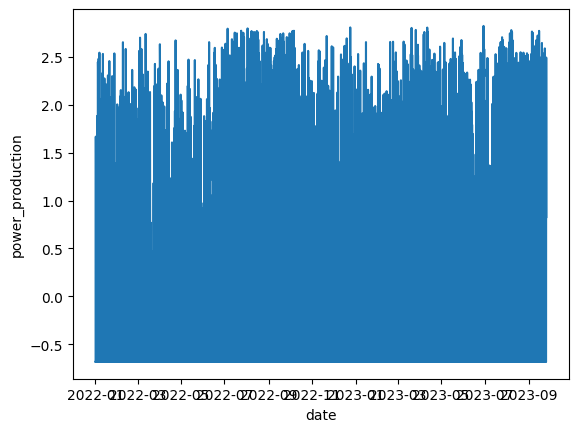

In [43]:
plt.xlabel('date')
plt.ylabel('power_production')
plt.plot(train)


In [9]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Values {key}: {value}')

adf_test(train['System Production (W)'])


ADF Statistic: -15.213078734016333
p-value: 5.619173288276242e-28
Critical Values 1%: -3.4307819953147396
Critical Values 5%: -2.8617309233706223
Critical Values 10%: -2.5668716238794587


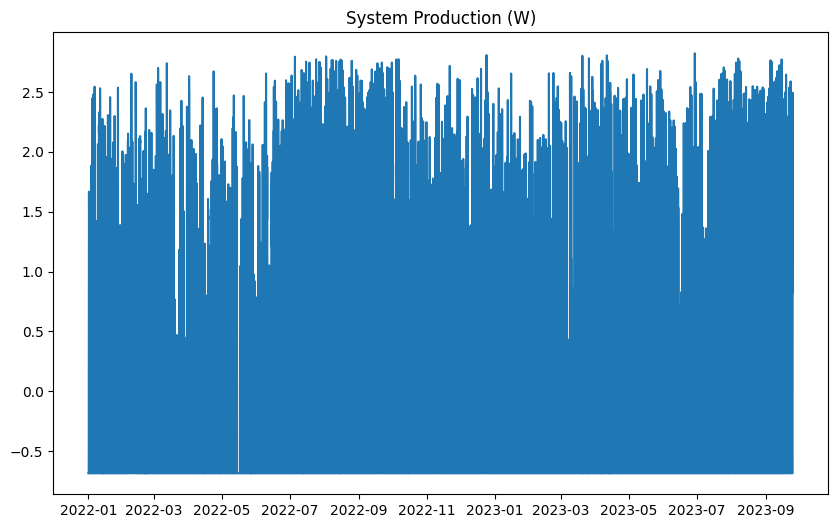

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(train['System Production (W)'])
plt.title('System Production (W)')
plt.show()

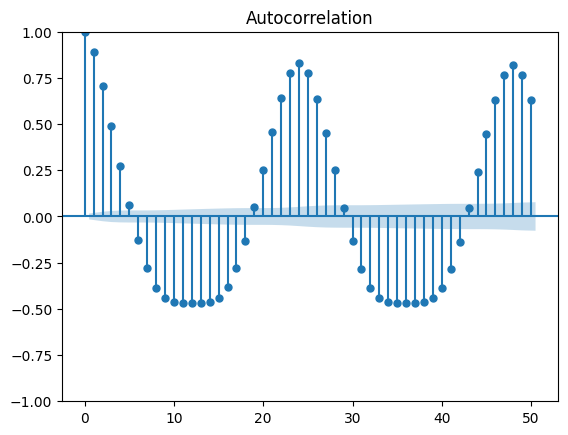

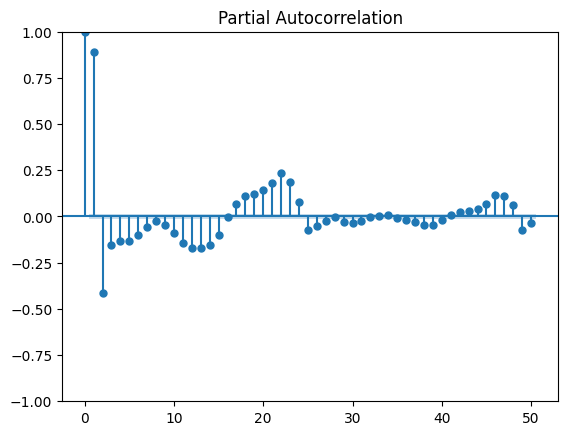

In [53]:
plot_acf(train['System Production (W)'], lags=50)
plot_pacf(train['System Production (W)'], lags=50)
plt.show()

## Grid Search for best parameters

In [11]:

train, valid = data_init()
# Step 3: Model Building
# Determine p, d, q
p = range(0, 3)  # Adjust based on PACF
q = range(0, 3)  # Adjust based on ACF
pdq = list(itertools.product(p, [0], q))
seasonal_pdq = [(x[0], 0, x[1], 24) for x in itertools.product(range(0, 2), range(0, 2))]  # Seasonal period is 24

# Fit the Seasonal ARIMA model
best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_mdl = SARIMAX(train['System Production (W)'],
                               order=param,
                               seasonal_order=param_seasonal,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
            res = temp_mdl.fit(disp=False)
            print(param, ' : ', param_seasonal, " AIC ", res.aic)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_mdl = res
        except:
            continue

print('Best ARIMA order:', best_order)
print('Best Seasonal ARIMA order:', best_seasonal_order)
print('Best AIC:', best_aic)

15184 2847 949
(0, 0, 0)  :  (0, 0, 0, 24)  AIC  43090.0172369698
(0, 0, 0)  :  (0, 0, 1, 24)  AIC  34753.423526003964
(0, 0, 0)  :  (1, 0, 0, 24)  AIC  25244.514473791536
(0, 0, 0)  :  (1, 0, 1, 24)  AIC  17850.6058613966
(0, 0, 1)  :  (0, 0, 0, 24)  AIC  29188.254340546642
(0, 0, 1)  :  (0, 0, 1, 24)  AIC  23878.181806271947
(0, 0, 1)  :  (1, 0, 0, 24)  AIC  17923.421467081425
(0, 0, 1)  :  (1, 0, 1, 24)  AIC  10818.368755345868
(0, 0, 2)  :  (0, 0, 0, 24)  AIC  22391.4549864039
(0, 0, 2)  :  (0, 0, 1, 24)  AIC  19281.760836773185
(0, 0, 2)  :  (1, 0, 0, 24)  AIC  15780.379328032446
(0, 0, 2)  :  (1, 0, 1, 24)  AIC  9049.611886707135
(1, 0, 0)  :  (0, 0, 0, 24)  AIC  19343.104693738907
(1, 0, 0)  :  (0, 0, 1, 24)  AIC  16684.884909986307
(1, 0, 0)  :  (1, 0, 0, 24)  AIC  14534.321359747071
(1, 0, 0)  :  (1, 0, 1, 24)  AIC  8478.071022968443
(1, 0, 1)  :  (0, 0, 0, 24)  AIC  17355.48874319101
(1, 0, 1)  :  (0, 0, 1, 24)  AIC  15684.23564497036
(1, 0, 1)  :  (1, 0, 0, 24)  AIC  14216.9

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2)  :  (1, 0, 1, 24)  AIC  8342.666100320977
Best ARIMA order: (1, 0, 1)
Best Seasonal ARIMA order: (1, 0, 1, 24)
Best AIC: 8340.454203016412


## Adding Exogenous Variables 

In [671]:
def create_lagged_features(df, column, lags):
    for lag in range(1, lags + 1):
        df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df

In [676]:
def data_init():
    train, valid, test =get_data()
    train = create_lagged_features(train, 'System Production (W)', 3)
    valid = create_lagged_features(valid, 'System Production (W)', 3)

    # Drop rows with NaN values created by lagging
    train = train.dropna().reset_index(drop=True)
    valid = valid.dropna().reset_index(drop=True)
    
    train = train[['Time','System Production (W)', 'System Production (W)_lag1',
                    'System Production (W)_lag2', 'System Production (W)_lag3',
                    'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 
                    'T2MWET', 'ALLSKY_SFC_PAR_TOT',
                    'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN',
                    'T2M', 'ALLSKY_KT', 'CLRSKY_SFC_PAR_TOT',
                    'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI',
                    'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA']]
    train['Time'] = pd.to_datetime(train['Time'])
    train.set_index('Time', inplace=True)
    train = train.asfreq('h')
    
    valid = valid[['Time','System Production (W)', 'System Production (W)_lag1',
                    'System Production (W)_lag2', 'System Production (W)_lag3',
                    'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 
                    'T2MWET', 'ALLSKY_SFC_PAR_TOT',
                    'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN',
                    'T2M', 'ALLSKY_KT', 'CLRSKY_SFC_PAR_TOT',
                    'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI',
                    'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA']]
    valid['Time'] = pd.to_datetime(valid['Time'])
    valid.set_index('Time', inplace=True)
    valid = valid.asfreq('h')
    
    train_exog = train[['System Production (W)_lag1',
                    'System Production (W)_lag2', 'System Production (W)_lag3',
                    'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 
                    'T2MWET', 'ALLSKY_SFC_PAR_TOT',
                    'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN',
                    'T2M', 'ALLSKY_KT', 'CLRSKY_SFC_PAR_TOT',
                    'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI',
                    'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA']]
    
    valid_exog = valid[['System Production (W)_lag1',
                    'System Production (W)_lag2', 'System Production (W)_lag3',
                    'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 
                    'T2MWET', 'ALLSKY_SFC_PAR_TOT',
                    'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN',
                    'T2M', 'ALLSKY_KT', 'CLRSKY_SFC_PAR_TOT',
                    'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI',
                    'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA']]
    
    
    # train['System Production (W)'] = np.log1p(train['System Production (W)'])
    # scaler = StandardScaler()
    # train['System Production (W)'] = scaler.fit_transform(train[['System Production (W)']])
    # valid['System Production (W)'] = scaler.transform(valid[['System Production (W)']])

    
    
    # Robust Scaler for System Production
    scaler = RobustScaler()
    train['System Production (W)'] = scaler.fit_transform(train[['System Production (W)']])
    valid['System Production (W)'] = scaler.transform(valid[['System Production (W)']])

    # Robust Scaler for all other variables
    variables = ['System Production (W)_lag1',
                    'System Production (W)_lag2', 'System Production (W)_lag3',
                    'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 
                    'T2MWET', 'ALLSKY_SFC_PAR_TOT',
                    'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN',
                    'T2M', 'ALLSKY_KT', 'CLRSKY_SFC_PAR_TOT',
                    'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI',
                    'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA']

    for var in variables:
        add_scaler = RobustScaler()
        train_exog[var] = add_scaler.fit_transform(train[[var]])
        valid_exog[var] = add_scaler.transform(valid[[var]])
    


    # train = train[['Time','System Production (W)']]
    # train['Time'] = pd.to_datetime(train['Time'])
    # train.set_index('Time', inplace=True)
    # train = train.asfreq('h')
    # test['System Production (W)'] = scaler.transform(test[['System Production (W)']])

    return train, valid, train_exog, valid_exog, scaler, add_scaler


train, valid, train_exog, valid_exog, scaler, add_scaler = data_init()
# # Step 3: Model Building
# # Determine p, d, q
# p = range(0, 4)  # Adjust based on PACF
# q = range(0, 4)  # Adjust based on ACF
# pdq = list(itertools.product(p, [0], q))
# seasonal_pdq = [(1, 0, 1, 24)]
# # seasonal_pdq = [(x[0], 0, x[1], 24) for x in itertools.product(range(0, 2), range(0, 2))]  # Seasonal period is 24

# # Fit the Seasonal ARIMA model
# best_aic = float("inf")
# best_order = None
# best_seasonal_order = None
# best_mdl = None

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             temp_mdl = SARIMAX(train['System Production (W)'],
#                                exog=train_exog,
#                                order=param,
#                                seasonal_order=param_seasonal,
#                                enforce_stationarity=False,
#                                enforce_invertibility=False)
#             res = temp_mdl.fit(disp=False)
#             print(param, ' : ', param_seasonal, " AIC ", res.aic)
#             if res.aic < best_aic:
#                 best_aic = res.aic
#                 best_order = param
#                 best_seasonal_order = param_seasonal
#                 best_mdl = res
#         except:
#             continue

# print('Best ARIMA order:', best_order)
# print('Best Seasonal ARIMA order:', best_seasonal_order)
# print('Best AIC:', best_aic)

Training Set:  15184 Validation Set:  2847 Test Set:  949


/var/folders/vv/v6qpc6ns2mv0rnx87x54tqhr0000gn/T/ipykernel_63819/731949047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_lag{lag}'] = df[column].shift(lag)
/var/folders/vv/v6qpc6ns2mv0rnx87x54tqhr0000gn/T/ipykernel_63819/731949047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_lag{lag}'] = df[column].shift(lag)
/var/folders/vv/v6qpc6ns2mv0rnx87x54tqhr0000gn/T/ipykernel_63819/731949047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [679]:
# Print the best model parameters
best_order = (1, 0, 1)
best_seasonal_order = (1, 0, 1, 24)


# Fit the model on the training set with exogenous variables
model = SARIMAX(train['System Production (W)'],
                exog=train_exog,
                order=best_order,
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False, maxiter=200)

# Forecast on the validation set using the exogenous variables from the validation data





/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: Input contains NaN.

In [687]:
forecast = model_fit.get_forecast(steps=len(valid), exog=valid_exog)
forecast_index = valid.index
forecast = pd.Series(forecast.predicted_mean, index=forecast_index)


In [788]:
valid

,System Production (W),System Production (W)_lag1,System Production (W)_lag2,System Production (W)_lag3,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_UV_INDEX,T2MWET,ALLSKY_SFC_PAR_TOT,ALLSKY_SRF_ALB,CLRSKY_SFC_SW_DWN,T2M,ALLSKY_KT,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_SW_DIFF,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA
Time,,,,,,,,,,,,,,,,,
2023-09-25 19:00:00,3.964499e+13,0.0,12304.086525,58505.305650,0.00,0.00,27.56,0.00,0.00,0.00,35.17,0.00,0.00,0.00,0.00,0.00,0.00
2023-09-25 20:00:00,3.964499e+13,0.0,0.000000,12304.086525,0.00,0.00,27.26,0.00,0.00,0.00,34.65,0.00,0.00,0.00,0.00,0.00,0.00
2023-09-25 21:00:00,3.964499e+13,0.0,0.000000,0.000000,0.00,0.00,27.19,0.00,0.00,0.00,33.68,0.00,0.00,0.00,0.00,0.00,0.00
2023-09-25 22:00:00,3.964499e+13,0.0,0.000000,0.000000,0.00,0.00,27.00,0.00,0.00,0.00,32.23,0.00,0.00,0.00,0.00,0.00,0.00
2023-09-25 23:00:00,3.964499e+13,0.0,0.000000,0.000000,0.00,0.00,26.22,0.00,0.00,0.00,31.10,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-22 02:00:00,3.964499e+13,0.0,0.000000,0.000000,0.00,0.00,25.86,0.00,0.00,0.00,26.04,0.00,0.00,0.00,0.00,0.00,0.00
2024-01-22 03:00:00,3.964499e+13,0.0,0.000000,0.000000,0.00,0.00,25.73,0.00,0.00,0.00,25.90,0.00,0.00,0.00,0.00,0.00,0.00
2024-01-22 04:00:00,3.964499e+13,0.0,0.000000,0.000000,0.00,0.00,25.64,0.00,0.00,0.00,25.82,0.00,0.00,0.00,0.00,0.00,0.00


In [787]:
forecast.sample(20)

Time
2023-10-13 16:00:00   -0.117057
2023-11-23 00:00:00   -0.018329
2023-12-31 17:00:00   -0.013540
2023-12-08 09:00:00    1.646087
2023-12-19 11:00:00    1.157896
2023-12-28 23:00:00   -0.027932
2023-12-27 06:00:00    1.127796
2023-11-26 15:00:00   -0.173513
2024-01-22 06:00:00         NaN
2023-11-20 17:00:00    0.021705
2023-12-13 08:00:00    1.991848
2023-11-06 03:00:00    0.175721
2023-12-23 03:00:00    0.076161
2024-01-08 16:00:00   -0.147219
2023-10-22 23:00:00   -0.035612
2023-10-13 01:00:00    0.010201
2024-01-15 05:00:00    0.817391
2023-10-11 17:00:00    0.071653
2024-01-19 20:00:00   -0.037193
2023-12-20 18:00:00   -0.020694
Name: predicted_mean, dtype: float64

In [794]:
forecast_inversed = scaler.inverse_transform(forecast.values.reshape(-1, 1))

np.isnan(forecast_inversed)



2844

In [ ]:
valid['System Production (W)'] = scaler.inverse_transform(valid[['System Production (W)']])

# Evaluate forecast accuracy
mae = mean_absolute_error(valid['System Production (W)'], forecast_inversed)
rmse = np.sqrt(mean_squared_error(valid['System Production (W)'], forecast_inversed))
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

In [685]:
forecast

Time
2023-09-25 19:00:00    0.038221
2023-09-25 20:00:00    0.014344
2023-09-25 21:00:00    0.005857
2023-09-25 22:00:00    0.001249
2023-09-25 23:00:00   -0.002010
                         ...   
2024-01-22 02:00:00   -0.037762
2024-01-22 03:00:00    0.035110
2024-01-22 04:00:00         NaN
2024-01-22 05:00:00         NaN
2024-01-22 06:00:00         NaN
Freq: h, Name: predicted_mean, Length: 2844, dtype: float64

## Prophet

In [621]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

def cap_outliers(data):
    capped_data = data.copy()
    lower_bound = data['System Production (W)'].quantile(0.05)
    upper_bound = data['System Production (W)'].quantile(0.95)

    capped_data['System Production (W)'] = np.where(capped_data['System Production (W)'] < lower_bound, lower_bound,
                                                    np.where(capped_data['System Production (W)'] > upper_bound, upper_bound,
                                                            capped_data['System Production (W)']))
    return capped_data

def create_lagged_features(df, column, lags):
    for lag in range(1, lags + 1):
        df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df
        

In [620]:
def get_data():
    file_path = '/Users/mubashirahmad/Library/CloudStorage/OneDrive-UniversityofHertfordshire/BDTI-Shared-Resources/Projects/On-Going/PowerBox/powerbox/powerbox/Data/processed_datasets/SI_SP_merged_filtered.csv'
    data = pd.read_csv(file_path, usecols=['Time', 'System Production (W)','ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 'T2MWET', 'ALLSKY_SFC_PAR_TOT', 'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN', 'T2M', 'ALLSKY_KT', 'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI', 'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA'])
    

    outliers = detect_outliers_iqr(data['System Production (W)'])
    if len(outliers) > 0:
        data = cap_outliers(data)
     
    n = len(data)
    train_size = int(n * 0.80)
    valid_size = int(n * 0.15)

    train_data = data.iloc[:train_size]
    valid_data = data.iloc[train_size:train_size + valid_size]
    test_data = data.iloc[train_size + valid_size:]
    
    
    print("Training set mean:", train_data['System Production (W)'].mean())
    print("Validation set mean:", valid_data['System Production (W)'].mean())

    print("Training set std dev:", train_data['System Production (W)'].std())
    print("Validation set std dev:", valid_data['System Production (W)'].std())
    
    
    
    return train_data, valid_data, test_data, data

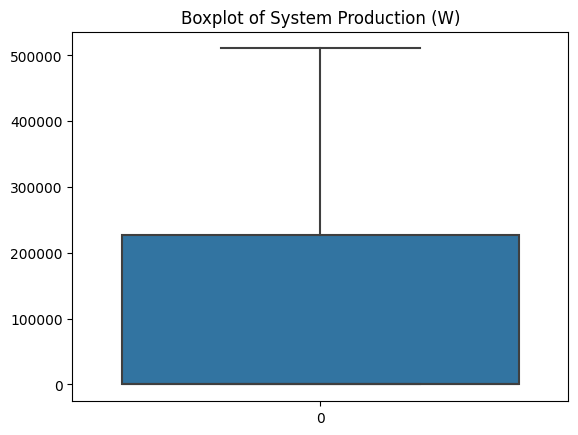

In [299]:
import seaborn as sns
sns.boxplot(data['System Production (W)'])
plt.title('Boxplot of System Production (W)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(data.index, data['System Production (W)'], label='Data')
plt.scatter(outliers.index, outliers, color='red', label='Outliers')
plt.xlabel('Index')
plt.ylabel('System Production (W)')
plt.legend()
plt.show()

In [639]:
latitude = '-2.947600'
longitude = '-60.028500'

# Initialize the observer
observer = ephem.Observer()
observer.lat = latitude
observer.lon = longitude

def is_production_time(time):
    # Set the date for the observer
    observer.date = time.strftime('%Y/%m/%d 00:00:00')

    # Calculate sunrise and sunset times
    sunrise = observer.next_rising(ephem.Sun()).datetime()
    sunset = observer.next_setting(ephem.Sun()).datetime()

    # Adjust times by subtracting 4 hours if needed
    sunrise = sunrise - timedelta(hours=5)
    sunset = sunset - timedelta(hours=3)

    # print('Time: ', time, 'Sunrise: ', sunrise, 'Sunset: ', sunset, 'production_time: ', int(sunrise <= time <= sunset))

    # Check if the time is between the adjusted sunrise and sunset times
    return int(sunrise <= time <= sunset)

In [663]:
def data_init():
    train, valid, test, data = get_data()
    
    # Ensure we are working with copies to avoid SettingWithCopyWarning
    train = train.copy()
    valid = valid.copy()

    train['Time'] = pd.to_datetime(train['Time'])
    train['production_time'] = train['Time'].apply(is_production_time)
    train['System Production (W)'] = train['System Production (W)'].replace(0, 0.001)
    valid['Time'] = pd.to_datetime(valid['Time'])
    valid['production_time'] = valid['Time'].apply(is_production_time)
    old_valid = valid.copy()
    # train = train[train.production_time == 1]
    # valid = valid[valid.production_time == 1]
    print(len(train), len(valid), len(test))
    
    
    
    # Create lagged features for 'System Production (W)' (using 3 lags as an example)
    train = create_lagged_features(train, 'System Production (W)', 3)
    valid = create_lagged_features(valid, 'System Production (W)', 3)

    # Drop rows with NaN values created by lagging
    train = train.dropna().reset_index(drop=True)
    valid = valid.dropna().reset_index(drop=True)
    

    # Robust Scaler for System Production
    # scaler = RobustScaler()
    # train['System Production (W)'] = scaler.fit_transform(train[['System Production (W)']])
    # valid['System Production (W)'] = scaler.transform(valid[['System Production (W)']])

    # Robust Scaler for all other variables
    variables = ['ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 'T2MWET', 'ALLSKY_SFC_PAR_TOT', 
                 'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN', 'T2M', 'ALLSKY_KT', 'CLRSKY_SFC_PAR_TOT', 
                 'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI', 'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA',
                 'System Production (W)_lag1','System Production (W)_lag2','System Production (W)_lag3']

    for var in variables:
        add_scaler = RobustScaler()
        train[var] = add_scaler.fit_transform(train[[var]])
        valid[var] = add_scaler.transform(valid[[var]])

    return train, valid, old_valid

In [561]:
train, valid, old_valid = data_init()
train.production_time.value_counts()
valid.production_time.value_counts()

Training set mean: 122298.18336686332
Validation set mean: 117672.39820501668
Training set std dev: 175933.27345979068
Validation set std dev: 168525.99642899155
15184 2847 949


production_time
1    1453
0    1391
Name: count, dtype: int64

In [562]:
train[['Time', 'System Production (W)', 'production_time']].sample(10)

,Time,System Production (W),production_time
141,2022-01-07 00:00:00,0.000000,0
10796,2023-03-26 23:00:00,0.000000,0
2946,2022-05-03 21:00:00,0.000000,0
1537,2022-03-06 04:00:00,0.000000,0
10944,2023-04-02 03:00:00,0.000000,0
6699,2022-10-07 06:00:00,67362.658200,1
5695,2022-08-26 10:00:00,510555.788672,1
4070,2022-06-19 17:00:00,10526.583075,1
9566,2023-02-03 17:00:00,50702.704775,1
14466,2023-08-26 21:00:00,0.000000,0


In [664]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error



train, valid, old_valid= data_init()

# Prepare data for Prophet
train_prophet = train.reset_index().rename(columns={'Time': 'ds', 'System Production (W)': 'y','System Production (W)_lag1':'add1',
                                                    'System Production (W)_lag2':'add2', 'System Production (W)_lag3':'add3',
                                                    'ALLSKY_SFC_SW_DWN': 'add4', 'ALLSKY_SFC_UV_INDEX': 'add5', 
                                                    'T2MWET':'add6', 'ALLSKY_SFC_PAR_TOT':'add7',
                                                    'ALLSKY_SRF_ALB':'add8', 'CLRSKY_SFC_SW_DWN':'add9',
                                                    'T2M':'add10', 'ALLSKY_KT':'add11', 'CLRSKY_SFC_PAR_TOT':'add12',
                                                    'ALLSKY_SFC_SW_DIFF':'add13', 'ALLSKY_SFC_SW_DNI':'add14',
                                                    'ALLSKY_SFC_UVB':'add15', 'ALLSKY_SFC_UVA':'add16'})

valid_prophet = valid.reset_index().rename(columns={'Time': 'ds', 'System Production (W)': 'y','System Production (W)_lag1':'add1',
                                                    'System Production (W)_lag2':'add2', 'System Production (W)_lag3':'add3',
                                                    'ALLSKY_SFC_SW_DWN': 'add4', 'ALLSKY_SFC_UV_INDEX': 'add5', 
                                                    'T2MWET':'add6', 'ALLSKY_SFC_PAR_TOT':'add7',
                                                    'ALLSKY_SRF_ALB':'add8', 'CLRSKY_SFC_SW_DWN':'add9',
                                                    'T2M':'add10', 'ALLSKY_KT':'add11', 'CLRSKY_SFC_PAR_TOT':'add12',
                                                    'ALLSKY_SFC_SW_DIFF':'add13', 'ALLSKY_SFC_SW_DNI':'add14',
                                                    'ALLSKY_SFC_UVB':'add15', 'ALLSKY_SFC_UVA':'add16'})

train_prophet = train_prophet[['ds', 'y', 'add1', 'add2', 'add3', 'add4', 'add5', 'add6', 'add7', 'add8', 'add9', 'add10', 'add11', 'add12', 'add13', 'add14', 'add15', 'add16']]
valid_prophet = valid_prophet[['ds', 'add1', 'add2', 'add3', 'add4', 'add5', 'add6', 'add7', 'add8', 'add9', 'add10', 'add11', 'add12', 'add13', 'add14', 'add15', 'add16']]

# Initialize Prophet model
model = Prophet(yearly_seasonality=True, 
                weekly_seasonality=False, 
                daily_seasonality=False, 
                
                )

# Add custom daily seasonality
model.add_seasonality(name='daily', period=24, fourier_order=200)

# Add all regressors
for i in range(1, 8):
    model.add_regressor(f'add{i}')

# Fit model
model.fit(train_prophet)

# Make predictions
future = valid_prophet.copy()
forecast = model.predict(future)

# Inverse transform predictions
final_forecast = forecast.copy()
# final_forecast['yhat'] = scaler.inverse_transform(final_forecast[['yhat']])

# Inverse transform validation data
# t = old_valid[old_valid.production_time == 0]
# t['yhat'] = 0
# t = t[['Time','System Production (W)', 'yhat']]

final_valid = valid.copy()
# final_valid['System Production (W)'] = scaler.inverse_transform(final_valid[['System Production (W)']])

# Merge forecast with validation set
final_valid = pd.merge(final_valid, final_forecast[['ds', 'yhat']], left_on='Time', right_on='ds', how='inner')
final_valid['yhat'] = final_valid['yhat'].apply(lambda x: 0 if x < 0 else x)
# final_valid['production_time'] = final_valid['Time'].apply(is_production_time)
# final_valid.loc[final_valid['production_time'] == 0, 'yhat'] = 0
# final_valid = final_valid[['Time', 'System Production (W)','yhat']]
# final_valid = pd.concat([t[['Time','System Production (W)', 'yhat']], final_valid[['Time','System Production (W)', 'yhat']]])
# final_valid = final_valid.sort_values(by='Time').reset_index(drop=True)

# Calculate errors
mae = mean_absolute_error(final_valid['System Production (W)'], final_valid['yhat'])
mse = mean_squared_error(final_valid['System Production (W)'], final_valid['yhat'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
# print(train_prophet['ds'].min(), train_prophet['ds'].max())
# df_cv = cross_validation(model, initial='300 days', period='60 days', horizon='90 days')
# df_p = performance_metrics(df_cv)
# print(df_p[['mae', 'mse', 'rmse']])

Training set mean: 122298.18336686332
Validation set mean: 117672.39820501668
Training set std dev: 175933.27345979068
Validation set std dev: 168525.99642899155
15184 2847 949


19:10:38 - cmdstanpy - INFO - Chain [1] start processing
19:10:53 - cmdstanpy - INFO - Chain [1] done processing


MAE: 23944.35918020426
MSE: 2236722154.520268


In [660]:
start_index = np.random.randint(0, len(final_valid) - 10)
temp_2 = final_valid.iloc[start_index:start_index + 10]
print(temp_2[['Time', 'System Production (W)', 'yhat']])

                    Time  System Production (W)           yhat
1309 2023-11-19 08:00:00          435105.585925  309583.142591
1310 2023-11-19 09:00:00          487204.757825  472846.318209
1311 2023-11-19 10:00:00          300599.007800  474914.594959
1312 2023-11-19 11:00:00          420742.539100  325506.972555
1313 2023-11-19 12:00:00          370758.164050  394073.919920
1314 2023-11-19 13:00:00          451423.593725  350383.297801
1315 2023-11-19 14:00:00          347906.042950  340229.777782
1316 2023-11-19 15:00:00          109494.286125  212787.422559
1317 2023-11-19 16:00:00           30503.133775    5457.182099
1318 2023-11-19 17:00:00            5978.694900       0.000000


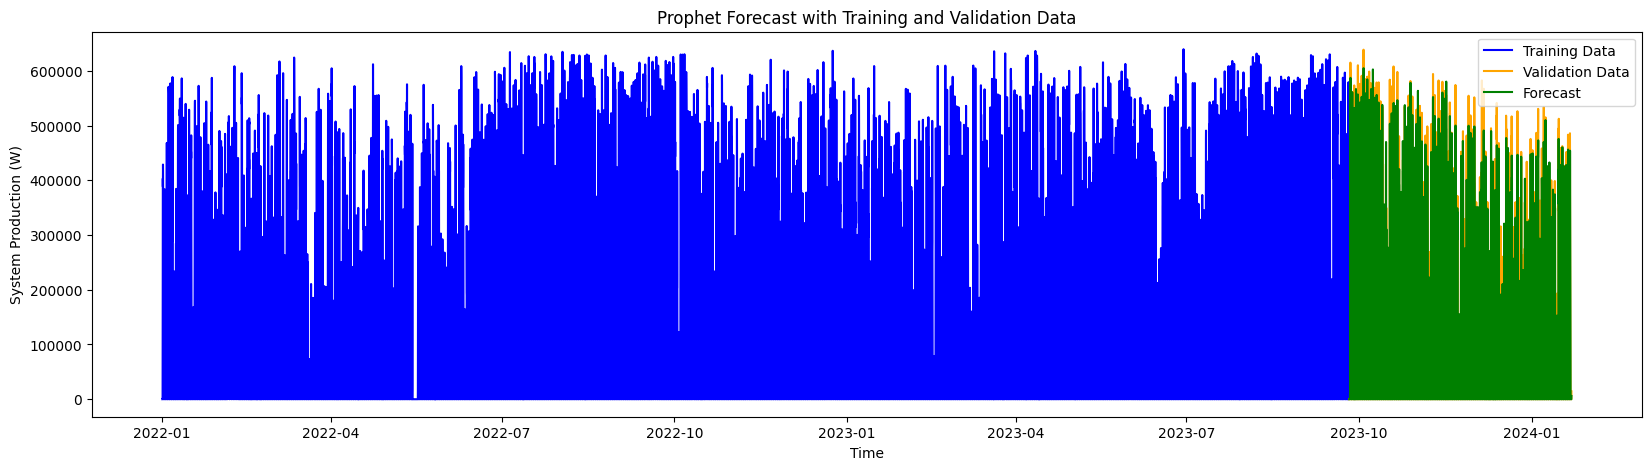

In [606]:
fig, ax = plt.subplots(figsize=(20, 5))

plt.plot(train['Time'], train[['System Production (W)']], label='Training Data', color='blue')

# # Plot the validation data
plt.plot(final_valid['Time'], final_valid['System Production (W)'], label='Validation Data', color='orange')

# # # Plot the forecast data
plt.plot(final_valid['Time'], final_valid['yhat'], label='Forecast', color='green')


# fig = model.plot(forecast, ax=ax)



# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('System Production (W)')
plt.title('Prophet Forecast with Training and Validation Data')
plt.legend()

plt.show()

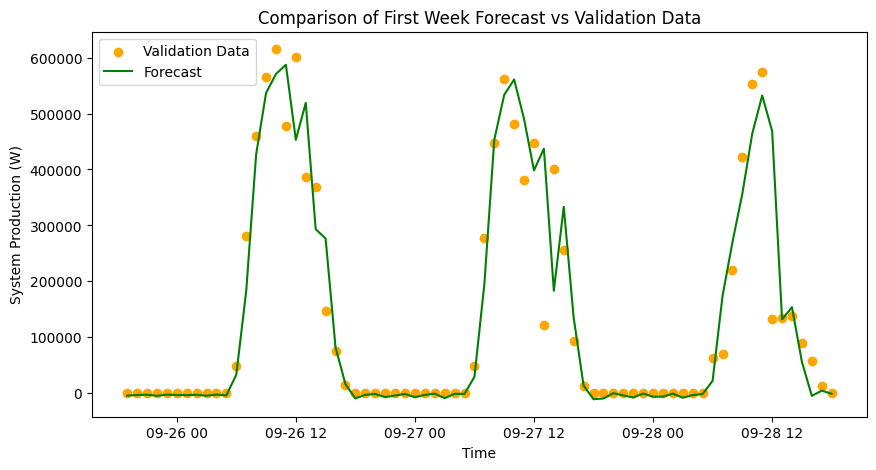

In [608]:
# forecast['ds'] = pd.to_datetime(forecast['ds'])
# valid['Time'] = pd.to_datetime(valid['Time'])

# Filter for the first week in the forecast
first_week_forecast = final_forecast[(final_forecast['ds'] >= final_valid['Time'].min()) & (final_forecast['ds'] < final_valid['Time'].min() + pd.Timedelta(hours=72))]

# Filter the validation data for the first week
first_week_valid = final_valid[(final_valid['Time'] >= final_valid['Time'].min()) & (final_valid['Time'] < final_valid['Time'].min() + pd.Timedelta(hours=72))]

# Plotting the first week of forecast vs validation
plt.figure(figsize=(10, 5))

# Plot the validation data
plt.scatter(first_week_valid['Time'], first_week_valid['System Production (W)'], label='Validation Data', color='orange')

# Plot the forecasted data
plt.plot(first_week_forecast['ds'], first_week_forecast['yhat'], label='Forecast', color='green')

# Customize the plot
plt.title('Comparison of First Week Forecast vs Validation Data')
plt.xlabel('Time')
plt.ylabel('System Production (W)')
plt.legend()

# Display the plot
plt.show()


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python date

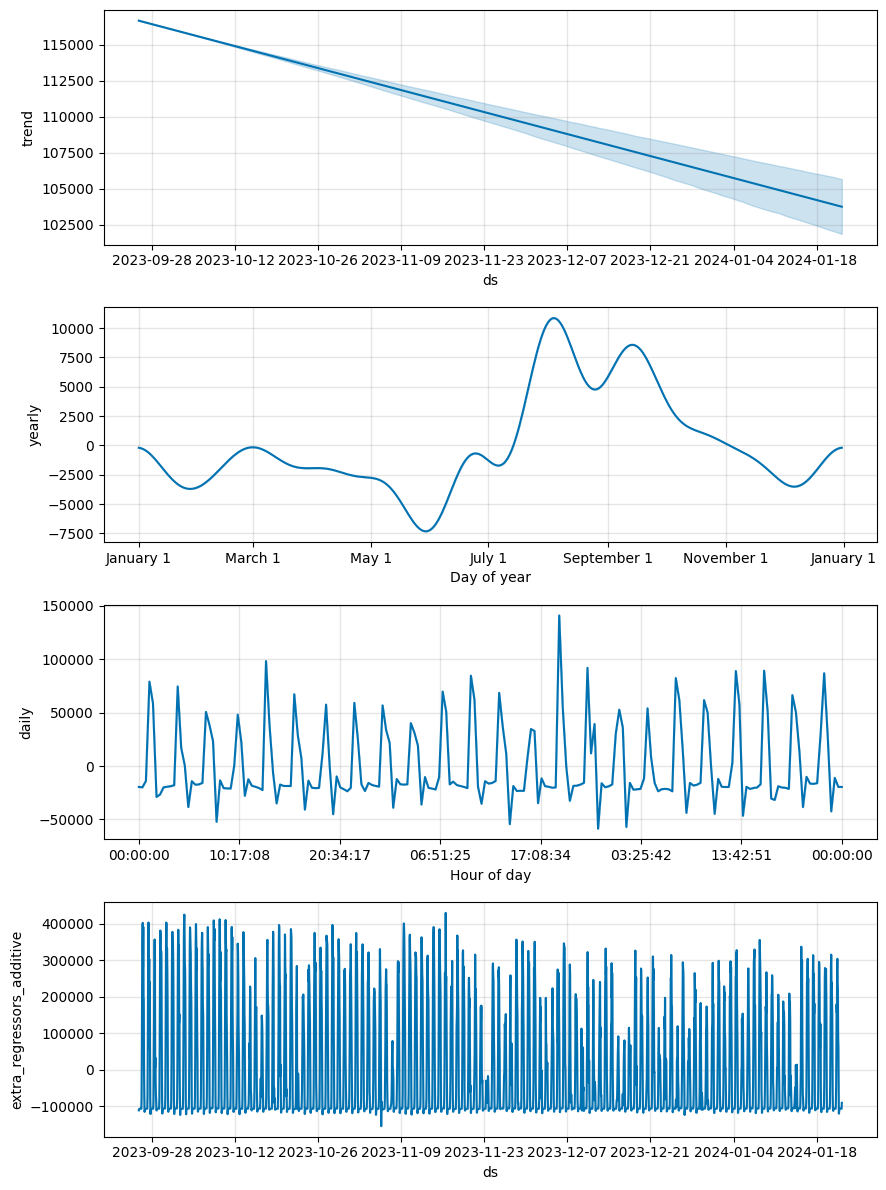

In [611]:
fig = model.plot_components(forecast)
plt.show()

## XGBoost